# Proyecto M1 - Modelo para clasificar géneros músicales
### José Emiliano Riosmena Castañón - A01704245

## Introducción
En este proyecto vamos a construir un modelo que sea capaz de distinguir a qué genero musical pertenece un fragmento de audio.

Para ello estaremos utilizando las herramientas de PySpark, ya que estaremos trabajando con una gran cantidad de datos, por lo que correrlo en un ambiente local, no nos sera posible debido a la capacidad del procesamiento de esta computadora.

Además, en este archivo encontraremos multiples visualizaciones acerca de los datos y de sus resultados en el modelo, lo que nos permitira tomar futuras decisiones sobre el desempeño del modelo o en general del dataset a utilizar.

## Descripción del Dataset
Anteriormente habiamos mencionado sobre el proposito general del modelo, poder determinar a qué genero musical pertenece un fragmento de audio. Por lo anterior, nuestro dataset es un conjunto de archivos de audio, cada uno es un fragmento de una canción de un género musical, y por ello están clasificados en diferentes subcarpetas dentro del dataset. Por ejemplo:
*   Metal
*   Rock
*   Pop
*   Reggae
*   Blues

Cada fragmento tiene una duración de 30 segundos, y para cada género, hay 100 muestras de estos fragmentos. Es decir, en cada subcarpeta tenemos 100 archivos de audio.

El dataset utilizado lo podemos encontrar en el siguiente link:

https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification


## Visualización del dataset
Vamos a ver unos cuantos detalles del dataset, para eso, realizaremos visualizaciones acerca de cómo están los datos y qué caracteristicas podemos obtener de ellos.

### Visualización del Tempo
En música, el tempo es la velocidad o rapidez con la que se interpreta una pieza musical. Se mide en pulsos por minuto, y nos permite establecer cuantos tiempos se escuchan en un minuto. Un tempo más alto indica que los latidos suceden con más frecuencia, haciendo que la música suende más animada o intensa, mientras que un tempo más lento genera una sensación de calma o solemnidad.

Utilizaremos la metadata del dataset para conocer el promedio de los tempos de los fragmentos de audio para cada género.

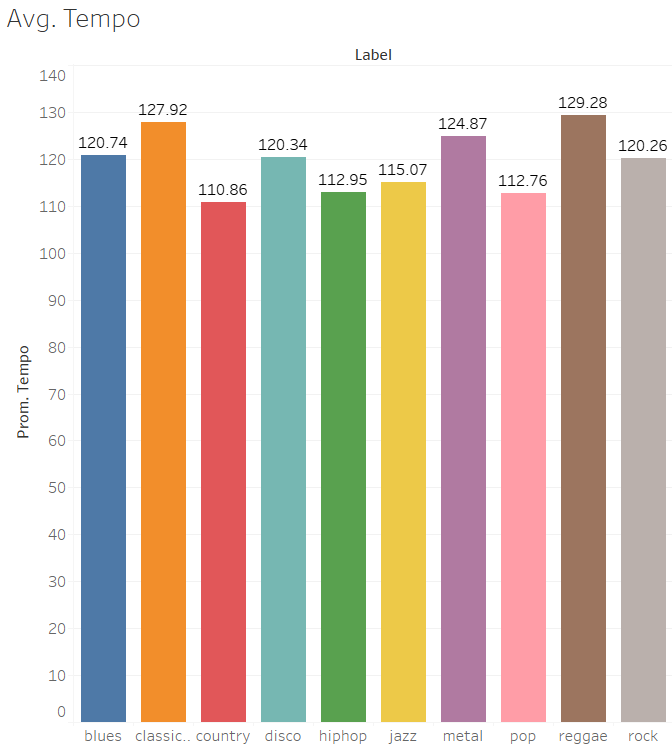

Para esta gráfica estamos midiendo el promedio de los tempos de cada fragmento de cada género. Podemos ver que en promedio el Reggae es el género que tiene mayor tempo en comparación con el resto de los géneros musicales. Seguido muy de serca por la música clásica. El resto de los géneros nos indican que en general tienen un tempo muy cercano, con muy poca diferencia entre cada género.

En general, casi todos los géneros musicales suelen tener un tempo entre 110 y 120 BPM, y con la gráfica podemos observar en mayor medida que es cierto, pues la mayoría de los géneros utilizados en este dataset, se encuentran en un rango de 110 y 120 BPM.

### Visualización de la duración

A continuación vamos a ver una distribución de la duración de los archivos. Anteriormente mencionabamos que todos los audios tienen una duración de 30 segundos, por lo que es muy probable que no se aprecien diferencias en el gráfico.

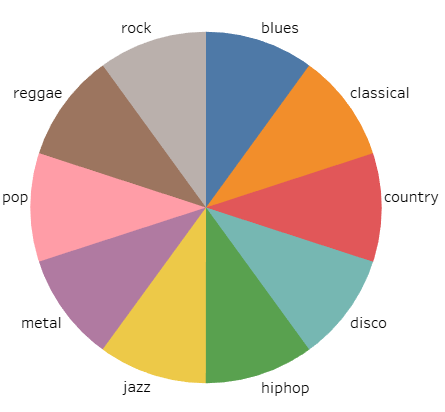

La gráfica nos muestra el promedio de la duración de los audios, a simple vista no se logran apreciar muchas diferencias a excepción de algunos, en los que se pueden ver que las rebanadas son un poco más grandes. Esto sugiere que si bien los audios son de 30 segundos, en cada uno existe una variación mínima de tiempo, indicando que puede haber muestras que duren un poco menos de 30 segundos o un poco más de 30 segundos, pero estas diferencias son mínimas, en milisegundos, por lo que esto no es un riesgo para que existan sesgos en el entrenamiento.

Ejemplo:
* 30.24 segundos
* 29.58 segundos

## Implementación

Ya hemos conocido un poco sobre la composición del dataset y cómo estan compuestos estos fragmentos de cada género musical, ahora vamos a implementar nuestro modelo con PySpark, y trataremos de que el modelo sea capaz de clasificar a qué genero musical corresponde un fragmento de audio.

## Instalamos las librerias necesarias para el modelo

Como mencionamos, vamos a estar trabajando con PySpark para poder preparar el ambiente para Big Data. Sin embargo, antes de querer hacer algo, debemos instalarlo en nuestro ambiente de colab, por lo que el primer paso es instalar Pyspark.

Además, vamos a estar trabajando con archivos de audio, cómo lo hemos mencionado en los puntos anteriores. Existen varias librerias de audio que podriamos utilizar para el procesamiento de nuestro archivo, en este caso, vamos a trabajar con la libreria "librosa", pues esta nos permite manipular de forma sencilla los archivos de audio, y poder modificarlos y adaptarlos a las necesidades de nuestro modelo.

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install pyspark librosa

## Creamos nuestro ambiente de trabajo
Vamos a configurar nuestra variable de entorno en colab. Para eso, la libreria de os, nos proporciona funciones para interactuar con el sistema operativo y nos permite acceder y modificar variables de entorno.

El módulo "environ" contiene las variables de entorno del sistema como pares clave-valor. Cada clave es el nombre de una variable de entorno. En este caso, estamos utilizando JAVA_HOME, esta nos permite indicar la instalación de Java en el sistema, y al asignarle el valor de la cadena, le decimos que busque en ese directorio específico.

In [2]:
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'

## Montamos nuestro modelo en Google Drive
Para este proyecto hemos alojado el dataset mencionado en Google Drive, por lo tanto, es necesario poder montar este archivo de colab en Google Drive, de ese modo podremos acceder al directorio del dataset y todos sus contenidos.

Para ello, permitimos el acceso a Google Drive y echamos un vistazo al contenido de la carpeta del dataset, deberemos ser capaces de encontrar las subcarpetas de los géneros musicales.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd "/content/drive/MyDrive/Colab Notebooks/Proyecto M1/Data/genres_original"
!ls

/content/drive/MyDrive/Colab Notebooks/Proyecto M1/Data/genres_original
blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock


## Creamos nuestro ambiente de PySpark
Aquí creamos la sesión de Spark, la cual es una forma de iniciar y gestionar la conexión con Apache Spark, con ella podremos procesar grandes volumenes de datos de forma distribuida. Como es el caso de nuestro dataset.

Para construir el ambiente de PySpark, utilizamos la propiedad builder, la cual nos permite configurar la sesión de Spark. Establecemos el nombre de la aplicación, en este caso, utilizararemos "MusicGenreClassification". Y le asignamos 2GB de memoria a cada proceso.

Por último finalizamos la construcción de la sesión de Spark y la iniciamos si no es que existe una. Si existe una sesión, utiliza esta ultima en lugar de crear una nueva.

In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("MusicGenreClassification") \
    .config("spark.executor.memory", "2g") \
    .getOrCreate()

spark

## Extraemos los archivos de audio y los guardamos en nuestro dataframe
Aquí vamos a procesar nuestros archivos de audio del dataset. Para ello vamos a extraer los MFCCs (coeficientes cepstrales en la escala de Mel), estas son caracterísitcas de un audio, se utilizan para analizar y clasificar sonidos. La cual se adapta a la necesidad de nuestro proyecto. Y consideramos que es apta para la solución.

La siguiente parte del código es extraer todas las características para cada archivo y las almacenamos en una lista. Esta ultima contiene tuplas de características y etiquetas, en este caso el género musical.

Después creamos un RDD y lo convertimos a un DataFrame. El RDD es una estructura distribuida que nos ayuda para realizar operaciones en paralelo. Sin embargo, utilizamos esta estructura para convertir el DataSet en un DataFrame. Le asignamos las columnas de "features" y label" para los géneros.

In [6]:
import librosa  # Library for audio processing
import numpy as np  # Library for numerical computations
import os  # Library for interacting with the operating system
from pyspark.sql.functions import col, lit  # PySpark functions for working with DataFrames

# Path to the dataset containing audio files, organized by genre
dataset_path = "/content/drive/MyDrive/Colab Notebooks/Proyecto M1/Data/genres_original"

def extract_features(file_path, label):
    """
    Extracts MFCC (Mel-frequency cepstral coefficients) features from an audio file.

    :param file_path: The path to the audio file.
    :param label: The label (genre) associated with the audio file.
    :return: A tuple containing the extracted MFCC features and the corresponding label.
    """
    try:
        # Load the audio file with a sample rate of 22050 Hz (default for librosa)
        audio, sr = librosa.load(file_path, sr=22050)

        # Extract 20 MFCCs from the audio signal
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)

        # Compute the mean of each MFCC across all time frames
        mfcc_mean = np.mean(mfccs.T, axis=0)

        # Return the MFCC features as a list along with the label
        return (mfcc_mean.tolist(), label)

    except Exception as e:
        # Handle any errors that occur during feature extraction
        print(f"Failed on: {file_path}: {e}")
        return None

# Initialize an empty list to store the extracted features and labels
data = []

# Loop through each genre folder in the dataset
for genre in os.listdir(dataset_path):
    genre_path = os.path.join(dataset_path, genre)  # Get the path to the genre folder

    # Check if the path corresponds to a directory
    if os.path.isdir(genre_path):
        # Loop through each audio file within the genre folder
        for file_name in os.listdir(genre_path):
            file_path = os.path.join(genre_path, file_name)  # Get the full path to the audio file

            # Extract features for the current audio file
            feature = extract_features(file_path, genre)

            # If feature extraction was successful, add the result to the data list
            if feature:
                data.append(feature)

# Create an RDD (Resilient Distributed Dataset) from the extracted data
rdd = spark.sparkContext.parallelize(data)

# Convert the RDD to a DataFrame with two columns: "features" and "label"
df = rdd.toDF(["features", "label"])

# Display the first 10 rows of the DataFrame
df.show(10)

<ipython-input-6-8314584fbee8>:19: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=22050)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Failed on: /content/drive/MyDrive/Colab Notebooks/Proyecto M1/Data/genres_original/jazz/jazz.00054.wav: 
+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-113.59882354736...|blues|
|[-207.52383422851...|blues|
|[-90.757164001464...|blues|
|[-199.57513427734...|blues|
|[-160.35417175292...|blues|
|[-177.80174255371...|blues|
|[-190.06880187988...|blues|
|[-179.37229919433...|blues|
|[-121.38979339599...|blues|
|[-213.26423645019...|blues|
+--------------------+-----+
only showing top 10 rows



Como hemos mencionado, los features obtenidos son los MFCC. Estos son una representación de las características fecuenciales del sonido y capturan información sobre el espectro de frecuencias en una escala logarítimica, similar a cómo el oído humano percibe el sonido. En otras palabras, describe la forma de la envolvente espectral del audio y nos permiten capturar la "textura" del sonido, ya que pueden identificar patrones de frecuencias que diferencian un género musical de otro.

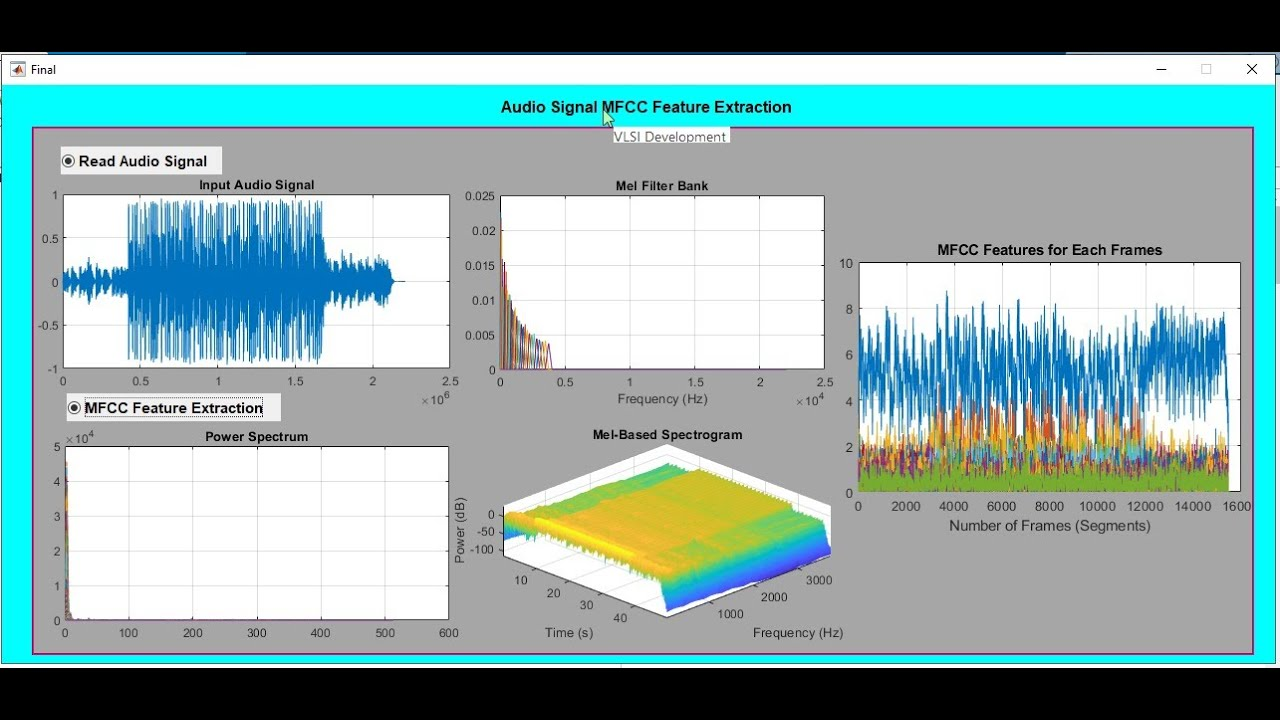

En este caso, la función extrae 20 coeficientes MFCC para cada archivo de audio. Como hemos mencionado, cada uno de estos coeficientes representa un aspecto diferente de la frecuencia en la escala de Mel, que reduce el impacto de las frecuencias extremas y enfatiza las que más percibe el oído humano.

Estos coeficientes se calculan en marcos temporales a lo largo del archivo de audio. Y se promedia cada uno de los coeficientes en todos los marcos temporales, lo que nos da una sola medida de cada coeficiente para el archivo completo. A continuación se muestran, estos coeficientes para cada uno de los archivos.

In [7]:
df.show(10, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                                                                                                                                                                                                                                                              |label|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Ya tenemos cada uno de los 20 coeficientes de MFCC para cada archivo en el dataset, para cada género. En el ejemplo de hoy podemos observar 10 muestras de estos datos ya convertidos, en este caso todos corresponden al género blues. Esto es porque estamos solicitando que solo nos muestre los primeros 10 datos del DataFrame. Vamos ahora a terminar de preparar nuestros datos y posteriormente vamos a realizar el entrenamiento del modelo.

## Preparamos los datos para el entrenamiento del modelo con Pyspark
En el parrafo anterior, mencionabamos que ya hemos preparado los datos para su uso, desde la extracción de caracterísiticas, y su conversión a un DataFrame. Sin embargo, aún nos falta un ultimo procesamiento en los datos para ue estos puedan ser utilizados en nuestro modelo con Spark.

En este caso, vamos a convertír las características en vectores densos y las etiquetas en índices numéricos. Para ello, convertimos el DataFrame a un RDD para poder aplicar una transformación a un map, la cual nos permite realizar operaciones en cada fila del RDD.

Con el módulo de Row, creamos un nuevo objeto de fila con la lista de características en un vector denso. Esto es necesario ya que Spark ML requiere que las características estén en un formato vectorial.

Volvemos a convertir el RDD transformado a un DataFrame, en este caso seguimos teniendo dos columnas, con la diferencia que la columna de los features están como un vector denso.

Posterior a eso, vamos a utilizar el módulo de StringIndexer para convertir la columna laber en índices numéricos. Le asignamos un número a cada género y lo aplicamos al DataFrame para aprender la correspondencia entre cada género y su índice numérico. Y por último, agregamos la columna con el índice numérico en el DataFrame.

In [8]:
from pyspark.ml.feature import VectorAssembler, StringIndexer  # Tools for feature engineering and label indexing
from pyspark.ml.linalg import Vectors  # Library for working with vectorized data
from pyspark.sql import Row  # Used to create Row objects for DataFrames

# Convert the "features" column to a dense vector and create a new DataFrame
df_vector = df.rdd.map(lambda row:
                       Row(features_vector=Vectors.dense(row['features']), label=row['label'])
                      ).toDF()

# Initialize a StringIndexer to convert the categorical "label" column to numeric indices
indexer = StringIndexer(inputCol="label", outputCol="label_index")

# Create a dictionary to map every index onto its categorical value
indexer_model = indexer.fit(df_vector)
labels_index = {i: label for i, label in enumerate(indexer_model.labels)}

# Fit the indexer on the data and transform the DataFrame to include the new "label_index" column
df_final = indexer.fit(df_vector).transform(df_vector)

# Display the first 10 rows with the vectorized features and the indexed labels
df_final.select("features_vector", "label_index").show(10)

+--------------------+-----------+
|     features_vector|label_index|
+--------------------+-----------+
|[-113.59882354736...|        0.0|
|[-207.52383422851...|        0.0|
|[-90.757164001464...|        0.0|
|[-199.57513427734...|        0.0|
|[-160.35417175292...|        0.0|
|[-177.80174255371...|        0.0|
|[-190.06880187988...|        0.0|
|[-179.37229919433...|        0.0|
|[-121.38979339599...|        0.0|
|[-213.26423645019...|        0.0|
+--------------------+-----------+
only showing top 10 rows



## Creamos nuestro modelo, utilizando Random Forest

Ya que tenemos los datos procesados y en el formato adecuado para PySpark, vamos a construir un modelo para poder clasificar el género musical de un fragmento de una canción.

Para este proyecto, utiliaremos Random Forest ya que al ser un método que combina múltiples árboles de decisión, reduce la probabilidad de overfitting. Permitiendonos mejorar la precisión en datos complejos. Además, Random Forest es útil para manejar múltiples clases sin hacer modificaciones, como es nuestro caso con los diferentes géneros musicales.

Para hacer el modelo, separamos los datos en training y test, y configuramos el clasificador Random Forest. Asignamos el vector de los features a la columna de entrada, y establecemos la columna de las etiquetas para los diferentes géneros, en formato numérico. Para este ejemplo, usaremos 100 árboles para hacer una predicción basada en el consenso de varios árboles.

In [9]:
from pyspark.ml.classification import RandomForestClassifier  # Import RandomForest model for classification tasks
from pyspark.ml.evaluation import MulticlassClassificationEvaluator  # Tool for evaluating classification models

# Split the data into training (80%) and testing (20%) sets with a fixed seed for reproducibility
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)

# Initialize the RandomForest classifier with 10 trees, specifying the feature and label columns
rf = RandomForestClassifier(featuresCol="features_vector", labelCol="label_index", numTrees=100)

# Train the RandomForest model using the training data
model = rf.fit(train_data)

## Generamos predicciones y mostramos los resultados del modelo
Ahora que tenemos nuestro modelo entrenado, es hora de ponerlo a prueba, vamos a determinar si el modelo es capaz de clasificar correctamente los fragmentos de audio a su respectivo género musical.

Anteriormente mencionabamos que convertimos cada género musical en un índice numérico para poder trabajar el modelo. A continuación se muestan cómo estan distribuidos los géneros con sus indices numéricos:

0. Blues
1. Classical
2. Country
3. Disco
4. Hiphop
5. Jazz
6. Metal
7. Pop
8. Reggae
9. Rock

Sabiendo esto, vamos a conocer los resultados del modelo.


In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Use the trained model to generate predictions on the test data
predictions = model.transform(test_data)

# Display the first 10 rows showing the predicted labels and actual labels
predictions.select("prediction", "label_index").show(50)

# Initialize an evaluator to measure the accuracy of the predictions
evaluator = MulticlassClassificationEvaluator(
    labelCol="label_index",  # The column with the true labels
    predictionCol="prediction",  # The column with the predicted labels
    metricName="accuracy"  # Metric to evaluate: accuracy
)

# Evaluate the model's accuracy on the test data
accuracy = evaluator.evaluate(predictions)

# Print the accuracy percentage with two decimal points
print(f"Model Accuracy: {accuracy * 100:.2f}%")

+----------+-----------+
|prediction|label_index|
+----------+-----------+
|       1.0|        1.0|
|       1.0|        1.0|
|       1.0|        1.0|
|       1.0|        1.0|
|       1.0|        1.0|
|       1.0|        1.0|
|       1.0|        1.0|
|       1.0|        1.0|
|       0.0|        0.0|
|       0.0|        2.0|
|       0.0|        0.0|
|       1.0|        1.0|
|       1.0|        1.0|
|       1.0|        1.0|
|       9.0|        0.0|
|       1.0|        1.0|
|       1.0|        1.0|
|       4.0|        1.0|
|       0.0|        0.0|
|       0.0|        0.0|
|       0.0|        0.0|
|       0.0|        0.0|
|       1.0|        1.0|
|       7.0|        4.0|
|       2.0|        4.0|
|       1.0|        1.0|
|       9.0|        2.0|
|       5.0|        4.0|
|       9.0|        1.0|
|       2.0|        2.0|
|       2.0|        2.0|
|       0.0|        0.0|
|       0.0|        0.0|
|       2.0|        2.0|
|       7.0|        4.0|
|       4.0|        4.0|
|       3.0|        3.0|


Este primer resultado nos muestra una comparación de el género predicho y su género real. En la tabla podemos ver que tenemos varias predicciones incorrectas. Además que el modelo tiene una precisión del 52.20%. Lo cual es bastante bajo para poder ser considerado efectivo. Por otro lado, también podemos decir que es un buen avance, pues crear un modelo que sea capaz de clasificar géneros musicales es algo que se escucha complicado, y haber logrado alcanzar un 52.20% en este primer acercamiento, es un buen indicador de que el modelo puede ser aún mejor y lograr predicciones correctas.

Veamos los demás resultados.

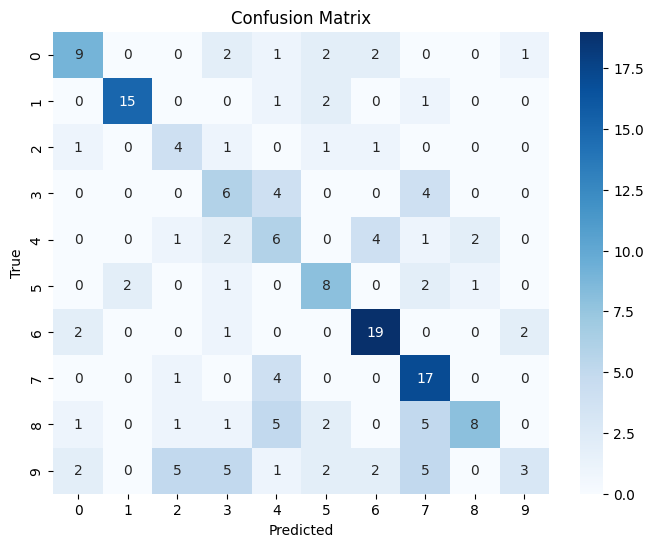

In [11]:
# Extract the predicted labels and the real labels
y_true = predictions.select("label_index").rdd.flatMap(lambda x: x).collect()
y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

# Convert indexes back to its original labels
y_true = [labels_index[i] for i in y_true]
y_pred = [labels_index[i] for i in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Show the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

La matríz de confusión nos muestra a detalle las predicciones de todos los géneros musicales, en ella podemos ver en cuantos se ha equivocado y en cuantos ha acertado, siendo estos últimos la diagonal de la matríz.

Los resultados para cada género, de acuerdo con la matríz de configuración, quedarian de la siguiente manera:

0. Blues: 9/15 → 60%
1. Classical: 15/17 → 88%
2. Country: 4/12 → 33%
3. Disco: 6/19 → 32%
4. Hiphop: 6/22 → 27%
5. Jazz: 8/17 → 47%
6. Metal: 19/28 → 68%
7. Pop: 17/35 → 49%
8. Reggae: 8/11 → 73%
9. Rock: 3/6 → 50%

Estos resultados nos dicen que el género clasico y metal son los que tienen un mejor desempeño y nos indican que el modelo tiene mayor facilidad para identificar estos dos géneros. Por otro lado el hiphop es el género más bajo, y el modelo tiene muchas dificultades para poder identificarlo. La matríz de confusión nos dice para este último género que tiende a confundirse con el Reggae, ya que el modelo penso en la mayoria de los casos que los fragmentos de Hiphop, eran de Reggae.

              precision    recall  f1-score   support

       blues       0.60      0.53      0.56        17
   classical       0.88      0.79      0.83        19
     country       0.33      0.50      0.40         8
       disco       0.32      0.43      0.36        14
      hiphop       0.27      0.38      0.32        16
        jazz       0.47      0.57      0.52        14
       metal       0.68      0.79      0.73        24
         pop       0.49      0.77      0.60        22
      reggae       0.73      0.35      0.47        23
        rock       0.50      0.12      0.19        25

    accuracy                           0.52       182
   macro avg       0.53      0.52      0.50       182
weighted avg       0.56      0.52      0.51       182



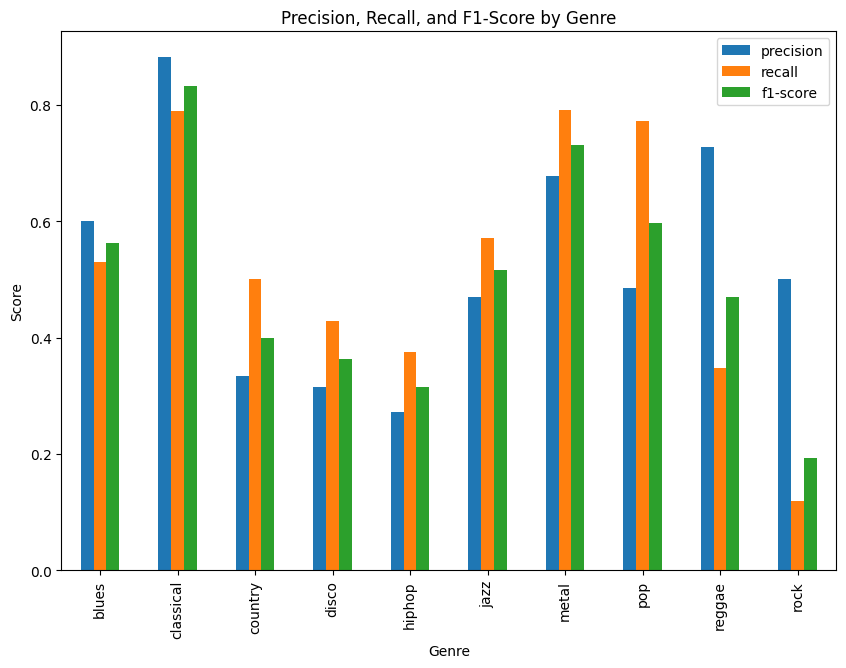

In [12]:
from sklearn.metrics import classification_report

# Generate the classification report
print(classification_report(y_true, y_pred))

# Extract data from classification report into a DataFrame
report = classification_report(y_true, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Display the classification report DataFrame
df_report[["precision", "recall", "f1-score"]].iloc[:-3].plot(kind="bar", figsize=(10, 7))
plt.title("Precision, Recall, and F1-Score by Genre")
plt.xlabel("Genre")
plt.ylabel("Score")
plt.show()

En esta gráfica estamos comparando precisión, recall y f1-score, los cuales nos sirven para evaluar a detalle modelos de clasificación como el que hicimos.

La precisión mide quétan relevante es lo que el modelo predice como postivo. En el caso de nuestro modelo, es como decir, si el modelo dice que un fragmento es de metal, ¿cuantas veces realmnte lo es?

El recall indica que tan bien el modelo encuentra todos los fragmentos de las canciones de un género en particular. Por ejemplo, ¿cuantos fragmentos de metal encuentra el modelo de todas las existentes?

Y por último, el F1-Score es el balance entre la precisión y el recall.

Según los resultados de la gráfica el género con mayor puntaje es el género clasico, pues las 3 métricas de evalación son casi perfectos, y bastante altos, por lo tanto, el modelo identifica con facilidad este género.

También, el género metal tien puntajes altos, particularmente en recall, lo que nos dice que el modelo logra encontrar la mayoría de los fragmentos de este género.

Podemos observar que el género de rock tienen un desempeño más bajo, particularmente en el recall y f1-score, sugiriendo que el modelo tiene dificultades para identificar estos géneros. Sin embargo, estos dos géneros tienen un precisión alta, por lo que el modelo puede predecirlos de forma correcta.

## Guardamos el modelo en Google Drive

Ya que hemos construido nuestro modelo, el ultimo paso es guardarlo, de este modo nos permitira tenerlo a la mano cuando queramos realizar futuras evaluaciones, por ejemplo a datos nuevos, en este caso, más fragmentos de los géneros musicales presentados en este dataset.

En este caso, el modelo se salva en mi carpeta local de Google Drive, sin embargo, puedes modificar la ruta libremente para ajustarla a tu ruta en Google Drive y de ese modo poder tener tu propia versión del modelo salvado.

In [13]:
# Define the path where the trained model will be saved
model_path = "/content/drive/MyDrive/Colab Notebooks/Proyecto M1/Model"

# Save the trained model to the specified path
model.save(model_path)

# Print a message indicating that the model has been successfully saved
print(f"Model saved at {model_path}")

Model saved at /content/drive/MyDrive/Colab Notebooks/Proyecto M1/Model


## Conclusiones del proyecto
Recapitulando lo visto en este documento. Hemos construido un modelo para poder clasificar diferentes géneros musicales. Para ello, hemos utilizado un dataset con una gran variedad de fragmentos de canciones de diferentes géneros musicales. Hemos realizado un análisis sobre cómo estamos utilizando los archivos de audio para el desarrollo del modelo, qué representan los resultados en comparación a lo que nosotros podemos percibir a simple oido. Y con ello, hemos podido constuir una aproximación de un modelo capaz de clasificar géneros musicales.

Los resultados del modelo indicarón que aún existe muchísimo margen de error con las predicciones de los géneros. Y el resultado de nuestro coeficiente R^2 en Testing (52.20%), si bien es más de la mitad, sigue siendo bastante bajo para decir que nuestro modelo es eficiente para clasificar géneros de forma correcta. Esto se debe a la diferencia de porcentajes obtenidos en los desempeños de los diferentes géneros. Ya que, aunqué tuvimos resultados muy positivos como fueron los géneros clasicos y metal, la mayoria tuvo desempeños más bajos y por ende, afectando la precisión del modelo.

Sin embargo, cómo conclusión personal, el resultado del modelo me deja bastante satisfecho, pues solamente imaginar el objetivo del proyecto, un modelo capaz de clasificar géneros musicales basado en diferentes fragmentos de canciones, suena bastante complicado. Además, en clase vimos muchos modelos y varios ejemplos, con diferentes tipos de datos, sin embargo, no vimos algun ejemplo en el que utilicemos archivos de audio. Por lo que el resultado obtenido en esta primera aproximación, me indica que el modelo va por un buen camino, y quizas con algunos ajustes más podriamos ser capaces de mejorar el desempeño del modelo, y logrando el objetivo principal en el futuro.